In [21]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'

from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality
from GRGN.Engines.Generator import Generator
from tsl.data import TemporalSplitter
import pandas as pd
from GRGN.Loss.LogLikelihood import LogLikelihood
from pytorch_lightning import Trainer
from tsl.utils.casting import torch_to_numpy
import matplotlib.pyplot as plt
from typing import Optional
from torch.utils.data import DataLoader

class CustomSpatioTemporalDataModule(SpatioTemporalDataModule):
    def train_dataloader(self, shuffle: bool = False,
                         batch_size: Optional[int] = None) \
            -> Optional[DataLoader]:
        """"""
        return self.get_dataloader('train', False, batch_size)

In [22]:
# filename = '/data/p.magos/TSGen/logs/generation/AirQuality/Best.ckpt'
filename = '/storagenfs/p.magos/TSGen/logs/generation/AirQuality/Model-model-epoch=00-val_loss=1.0685.ckpt'

In [23]:
filename

'/storagenfs/p.magos/TSGen/logs/generation/AirQuality/Model-model-epoch=00-val_loss=1.0685.ckpt'

In [24]:
dataset = AirQuality(impute_nans=True, small=True)

adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe()[-1100:],
                                    covariates=None,
                                    connectivity=adj,
                                    window=1,
                                    stride=1)
splitter = TemporalSplitter(0.5, 0)
scalers = {'target': StandardScaler(axis=(0, 1))}
dm = CustomSpatioTemporalDataModule(
    dataset=torch_dataset,
    splitter=splitter,
    scalers=scalers,
    batch_size=1,
    workers=8)
dm.setup(stage='fit') 

# if cfg.get('in_sample', False):
dm.trainset = list(range(len(torch_dataset)))

In [25]:
# setup generator
generator = Generator.load_from_checkpoint(filename)

In [26]:
trainer = Trainer()

trainer.ckpt_path= filename

generator.freeze()
# trainer.test(generator, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
print(generator.hparams)
loss_fn = LogLikelihood()

"metrics":              {'Loss': LogLikelihood()}
"model_class":          <class 'GRGN.GRGNModel.GRGNModel'>
"model_kwargs":         {'n_nodes': 36, 'input_size': 1, 'hidden_size': 16, 'mixture_size': 1, 'exclude_bwd': False}
"optim_class":          <class 'torch.optim.rmsprop.RMSprop'>
"optim_kwargs":         {'lr': 0.0001, 'weight_decay': 0.01}
"scale_target":         True
"scheduler_class":      <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
"scheduler_kwargs":     {'eta_min': 1e-05, 'T_max': 50}
"teacher_forcing_prob": 1.0


In [28]:
output = trainer.predict(generator, dataloaders=dm.train_dataloader())
output = generator.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
test_true = scalers['target'].transform(torch.tensor(y_true))
res = dict(test_mae=loss_fn.loss_function(torch.tensor(y_hat), torch.tensor(test_true)))
res['test_mae']/2

Restoring states from the checkpoint path at /storagenfs/p.magos/TSGen/logs/generation/AirQuality/Model-model-epoch=00-val_loss=1.0685.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Loaded model weights from the checkpoint at /storagenfs/p.magos/TSGen/logs/generation/AirQuality/Model-model-epoch=00-val_loss=1.0685.ckpt


Predicting DataLoader 0:   0%|          | 0/1099 [00:00<?, ?it/s]

Only args ['edge_index', 'x', 'edge_weight'] are forwarded to the model (GRGNModel). 


Predicting DataLoader 0: 100%|██████████| 1099/1099 [00:18<00:00, 60.32it/s]


/tmp/ipykernel_2894935/3434203760.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = dict(test_mae=loss_fn.loss_function(torch.tensor(y_hat), torch.tensor(test_true)))


tensor([0.4190])

In [29]:
y_true = torch.Tensor(y_true)
y_true.shape

torch.Size([1099, 1, 36, 1])

In [30]:
kwargs = {'scaler': scalers['target']}
input = y_true[-1000:-999]
generation = generator.generate(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), None, 1000, **kwargs)

Generating:   0%|          | 0/1000 [00:00<?, ?step/s]

Generating: 100%|██████████| 1000/1000 [00:08<00:00, 111.77step/s]


In [31]:
true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
generation = generation.reshape(generation.shape[0], generation.shape[-2])
generation.shape

torch.Size([1000, 36])

In [32]:
X = true[:]
Y = generation

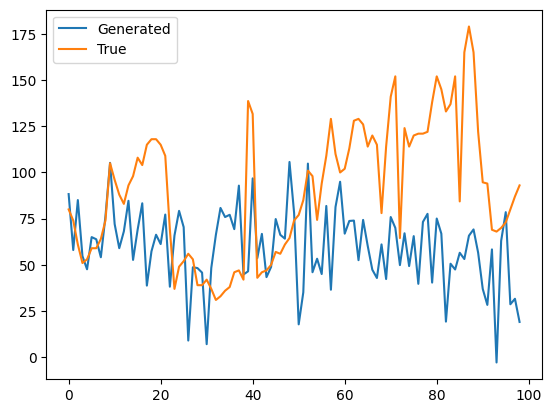

In [33]:
# plt.plot(generation[-500:-400, 35], label='Generated')
# plt.plot(true[-499:-399, 35], label='True')

plt.plot(generation[-99:, 2], label='Generated')
plt.plot(true[-99:, 2], label='True')


plt.legend()

In [34]:
y_true.shape

input = y_true[-100:]
# input = scalers['target'].transform(input)
input.shape
prediction = generator.predict(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), both_mean=True, **kwargs)

Predicting: 100%|██████████| 100/100 [00:00<00:00, 107.93step/s]


In [35]:
prediction = prediction.reshape(prediction.shape[0], prediction.shape[-2])
prediction.shape

torch.Size([100, 36])

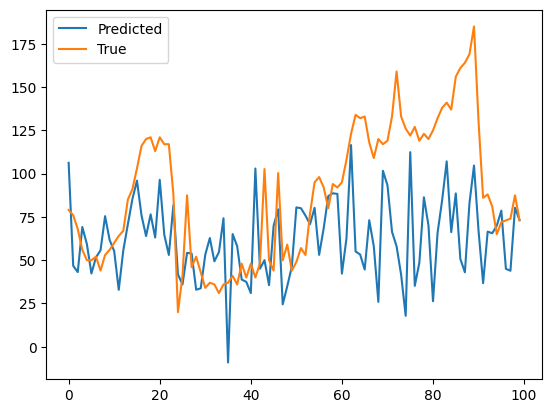

In [36]:
# plt.plot(prediction[-100:, 1], label='Predicted')
# plt.plot(true[-100:, 1], label='True')

plt.plot(prediction[-100:, 1], label='Predicted')
plt.plot(true[-100:, 1], label='True')


# plt.plot(prediction[:, 100], label='Predicted')
# plt.plot(true[-99:, 100], label='True')
plt.legend()

In [37]:
X = true
Y = prediction

In [38]:
err = torch.square(prediction[-99:] - true[-99:])
err.mean()

tensor(2142.6628)

In [39]:
cols = [1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036]
df = pd.DataFrame(generation, columns=cols)

In [40]:
df.to_csv('SynteticAirQualityGRGN.csv', index=False)